<a href="https://colab.research.google.com/github/MosheWasserb/PyTorchNotbooks/blob/master/MultiClassEmotionGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import pandas as pd

#cars = {'Brand': ['Honda Civic','Toyota Corolla','Ford Focus','Audi A4'],
        'Price': [22000,25000,27000,35000]
        }

#df = pd.DataFrame(cars, columns= ['Brand', 'Price'])

In [0]:
import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [45]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


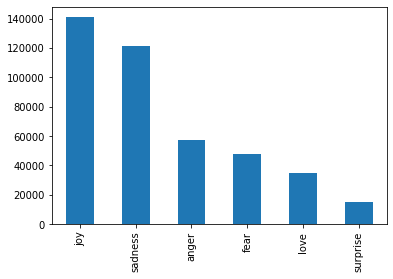

In [70]:
# load data
data = pd.read_csv(r"/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/multiclass6ed.csv")
data.emotions.value_counts().plot.bar()

In [71]:
data.head(5)

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


### 3.1 Preprocessing Data
In the next steps we are going to create tokenize the text, create index mapping for words, and also construct a vocabulary. 

#### Tokenization and Sampling

In [0]:
# retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# sampling
data = data.sample(n=5000);

#### Constructing Vocabulary and Index-Word Mapping

In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [92]:
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

# examples of what is in the vocab
inputs.vocab[0:10]

['a',
 'aac',
 'abandon',
 'abandoned',
 'abated',
 'abc',
 'abdicate',
 'abdul',
 'abg',
 'abide']

### 3.2 Converting Data into Tensors 
For convenience we would like to convert the data into tensors. 

In [0]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [94]:
# examples of what is in the input tensors
input_tensor[0:2]
type(input_tensor)

list

In [95]:
print(input_tensor[0:3])

[[3529, 2652, 4263, 7365], [3529, 7895, 2500, 4754, 3307, 7362, 5731, 269, 2655, 209, 3525, 269, 6375], [3529, 4992, 2652, 4186, 3566, 5110, 3424]]


### 3.3 Padding data
In order to train our recurrent neural network later on in the notebook, it is required padding to generate inputs of same length.

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [97]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

66


In [0]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [0]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [100]:
input_tensor[0:2]

[array([3529, 2652, 4263, 7365,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([3529, 7895, 2500, 4754, 3307, 7362, 5731,  269, 2655,  209, 3525,
         269, 6375,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])]

In [101]:
data.head(5)


,text,emotions,token_size
162476,i feel lonely today,sadness,4
333695,i was expecting my heart to race and feeling a...,fear,13
222437,i often feel like im overwhelmingly homesick,sadness,7
42442,when i had not understood anything after a lec...,sadness,9
182289,i used to feel helpless feel frustrated feel d...,fear,10


### 3.4 Binarization
We would like to binarize our target so that we can obtain one-hot encodings as target values. These are easier and more efficient to work with and will be useful when training the models.

In [0]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [103]:
target_tensor[0:2] 

array([[0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0]])

In [104]:
data[0:2]

,text,emotions,token_size
162476,i feel lonely today,sadness,4
333695,i was expecting my heart to race and feeling a...,fear,13


In [0]:
get_emotion = lambda t: np.argmax(t)

In [106]:
get_emotion(target_tensor[0])

4

In [0]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [108]:
emotion_dict[get_emotion(target_tensor[0])]

'sadness'

### 3.5 Split data
We would like to split our data into a train and validation set. In addition, we also want a holdout dataset (test set) for evaluating the models.

In [109]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(4000, 4000, 500, 500, 500, 500)

### 3.6 Data Loader
We can also laod the data into a data loader, which makes it easy to **manipulate the data**, **create batches**, and apply further **transformations**. In PyTorch we can use the `DataLoader` function.

In [0]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [0]:
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [0]:
val_dataset.batch_size



64

## 4. Model
After the data has been preprocessed, transformed and prepared it is now time to construct the model or the so-called computation graph that will be used to train our classification models. We are going to use a gated recurrent neural network (GRU), which is considered a more efficient version of a basic RNN. The figure below shows a high-level overview of the model details. 

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/gru-model.png?raw=true)

### 4.1 Constructing the Model
Below we construct our model:

In [115]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

NameError: ignored

### 4.2 Pretesting model
Since eager execution is enabled we can print the output of the model by passing a sample of the dataset and making sure that the dimensions of the outputs are the expected ones.

In [0]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# obtain one sample from the data iterator
it = iter(train_dataset)
x, y, x_len = next(it)

# sort the batch first to be able to use with pac_pack sequence
xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", xs.size())

output, _ = model(xs.to(device), lens, device)
print(output.size())

Input size:  torch.Size([68, 64])
torch.Size([64, 6])
